# Exercise B03: Bayesian Inverse Problems

In this notebook, we explore uncertainty quantification for inverse problems through Bayesian inference using CUQIpy.

Essentially, inverse problems aim to infer a set of unknown parameters of interest given a forward model and observed data. Within the realm of uncertainty quantification, the focus is on the uncertainty associated with these inferred parameters.

In the Bayesian framework, uncertainty is quantified by a probability distribution over the parameter space. To estimate this uncertainty, Bayesian inference utilizes Bayes' theorem to define the *posterior distribution* of the parameters by combining prior knowledge and observed data.

This notebook aims to demonstrate the use of CUQIpy to combine the all the components required for Bayesian inference in a way that closely matches the mathematical formalism.

The online documentation for CUQIpy can be found at [https://cuqi-dtu.github.io/CUQIpy/](https://cuqi-dtu.github.io/CUQIpy/). Throughout the notebook, we will link to the relevant sections of the documentation for further details.

## Learning objectives
Going through the notebook, you will see how to quantify the uncertainty for an example inverse problem using the CUQIpy library by learning how to:

* Define distributions for each of the relevant parameters in an inverse problem.
* Define and sample a Bayesian inverse problem.
* Construct explicitly a posterior distribution by conditioning the joint distribution on observed data.
* Sample a posterior distribution with specific choice of sampler.
* Analyze the samples from the posterior distribution.
* Compute point estimates of posterior, e.g., MAP or ML.
* Describe how the high-level "BayesianProblem" combines the above steps into a convenient non-expert interface.


## Table of contents
1. [Defining and sampling a Bayesian Inverse Problem (high-level)](#BIP)
2. [Defining and sampling a Bayesian Inverse Problem (low-level)](#Joint)
3. [Exploring different prior choices](#ModifyPriors)
4. [Computing point estimates of the posterior](#pointestimates) ★

The section marked with ★ is optional and can be skipped if you are short on time.

## References
[1] Gelman, Andrew, et al. "Bayesian workflow." arXiv preprint arXiv:2011.01808 (2020) https://arxiv.org/abs/2011.01808.

[2] Riis, Nicolai AB, et al. "CUQIpy--Part I: computational uncertainty quantification for inverse problems in Python." arXiv preprint arXiv:2305.16949 (2023) https://arxiv.org/abs/2305.16949.


## Load modules
We start of by importing the Python packages we need (including CUQIpy).

In [189]:
import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import JointDistribution, Gaussian, CMRF, LMRF, GMRF
from cuqi.sampler import LinearRTO, pCN, CWMH, ULA, MALA, NUTS
from cuqi.problem import BayesianProblem


# 1. Defining and sampling a Bayesian Inverse Problem (high-level)<a class="anchor" id="BIP"></a>

Solving a Bayesian inverse problem amounts to characterizing the posterior distribution.

The posterior describes the probability distribution of the parameters we are interested in. This is achieved by combining prior knowledge of the parameters and observed data. In its most general form, the posterior is given by Bayes' theorem:

\begin{align*}
p(\boldsymbol{\theta} \mid \mathbf{y}) = \frac{p(\mathbf{y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathbf{y})} \propto p(\mathbf{y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}),
\end{align*}

where $\boldsymbol{\theta}$ is the parameter vector of *all* the parameters we are interested in inferring and $\mathbf{y}$ is the observable data. In the simplest case one could have a single parameter vector of interest, say $\boldsymbol{\theta}=[\mathbf{x}]$.

The probability density function $p(\boldsymbol{\theta})$ is the prior distribution of the parameters.

Given fixed observed data $\mathbf{y}_\mathrm{data}$, the term $p(\mathbf{y} \mid \boldsymbol{\theta})$ considered as a function of $\boldsymbol{\theta}$ is known as the
likelihood function or just *likelihood*, also denoted $L(\boldsymbol{\theta} \mid \mathbf{y} = \mathbf{y}_\mathrm{data})$, which we note is not a probability density but a density function.

When $\mathbf{y}$ is not fixed, $p(\mathbf{y} \mid \boldsymbol{\theta})$ is a probability density function of the data $\mathbf{y}$ given the value of the parameters $\boldsymbol{\theta}$. In CUQIpy we refer to this distribution as the *data distribution*.

The denominator $p(\mathbf{y})$ is the *evidence* and is a normalization constant (that we typically ignore because it does not affect the MCMC sampling) that ensures that the posterior integrates to 1.


### Note on Bayesian inverse problems with CUQIpy

CUQIpy uses a general approach to Bayesian modeling that not only aims to define the posterior distribution, but instead to define the joint distribution of all the parameters. This more general approach is useful because it allows one to carry out more tasks related to uncertainty quantification of inverse problems such as prior-predictive checks, model checking, posterior-predictive checks and more. For more details on some of these topics see the overview in [1].

In this notebook, we initially focus on how to define and sample a Bayesian inverse problem using the high-level interface in CUQIpy. We then later show a more low-level approach to defining the posterior distribution, which is useful for users who want to have more control the type of sampler used for sampling the posterior distribution.

## 1.1 Deterministic forward model and observed data
Consider a Bayesian inverse problem
$$
\mathbf{y}=\mathbf{A}\mathbf{x} + \mathbf{e},
$$

where $\mathbf{A}: \mathbb{R}^n \to \mathbb{R}^m$ is the (deterministic) forward model of the inverse problem and $\mathbf{y}$ and $\mathbf{x}$ are random variables representing the observed data and parameter of interest respectively. Here $\mathbf{e}$ is a random variable representing additive noise in the data.

For this example let us consider the `Deconvolution1D` testproblem and extract a CUQIpy forward model and some synthetic data denoted $\mathbf{y}_\mathrm{data}$ (a realization of $\mathbf{y}$). 

Note that this is a linear inverse problem, but the same approach can be used for nonlinear inverse problems.

In [1]:
# Load forward model, data and problem information
A, y_data, probInfo = Deconvolution1D(phantom="sinc").get_components()

# For convenience, we define the dimension of the domain of A
n = A.domain_dim

# For convenience, we extract the exact solution as x_exact
x_exact = probInfo.exactSolution


NameError: name 'Deconvolution1D' is not defined

Before going further let us briefly visualize the data and compare with the exact solution to the problem.

Here we should expect to see that the data is a convolved version of the exact solution with some added noise. We can also inspect the `probInfo` variable to get further information about the problem.

ProblemInfo with the following set attributes:
['infoString', 'exactSolution', 'exactData']
 infoString: Noise type: Additive Gaussian with std: 0.01


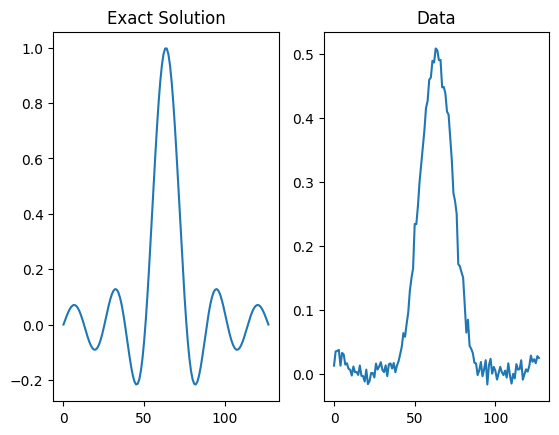

In [191]:
# Plot the data
plt.subplot(121); x_exact.plot(); plt.title('Exact Solution')
plt.subplot(122); y_data.plot(); plt.title('Data')

# Print information about the problem
print(probInfo)


## 1.2 Distributions for parameters and data

The goal now is to define distributions for each the random variables that represent the parameters and data in the above-mentioned Bayesian inverse problem. One way to think about this, is that we are trying to define a statistical model for the data generating process (see reference [1]), which we call a *Bayesian Problem* in CUQIpy.

For the unknown $\mathbf{x}$, we use a-priori knowledge to define its distribution. In this case, the sinc phantom in the Deconvolution test problem can be represented fairly well by a distribution that generates smooth, but spatially correlated realizations.

One such distribution is the Gaussian Markov Random Field (GMRF) distribution. This distribution assumes a Gaussian distribution on the differences between neighboring elements of $\mathbf{x}$, i.e. in 1D:

\begin{align*}
x_i - x_{i-1} \sim \mathrm{Gaussian}(0, d^{-1}), \quad i=1, \ldots, n,
\end{align*}

where we purposely leave out the details on the boundary conditions for this notebook.

To simplify the notation, we denote by *GMRF* the distribution that induces this property on a vector $\mathbf{x}$ defined by its mean and precision $d$. That is, the above can be written as

\begin{align*}
\mathbf{x} &\sim \mathrm{GMRF}(\mathbf{0}, d),
\end{align*}


with some choice of the precision say $d=50$. For more details on GMRF see the first CUQIpy paper [2].

The GMRF distribution is implemented in CUQIpy as [GMRF class](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.GMRF.html#cuqi.distribution.GMRF) and can be used as follows:

In [192]:
# Define prior precision
d = 50

# Define GMRF prior (zero boundary conditions are the default)
x = GMRF(np.zeros(n), d)


From the problem info string earlier, we saw that the noise is Gaussian with standard deviation $s_\mathbf{e}=0.01$, i.e.,

\begin{align*}
\mathbf{e} &\sim \mathrm{Gaussian}(\mathbf{0}, s_\mathbf{e}^2 \mathbf{I}).
\end{align*}

Instead of working directly with the noise variable $\mathbf{e}$, we can include the stochastic element of the noise in the random variable $\mathbf{y}$ representing the data.

Because the data depend on $\mathbf{x}$ we are really interested in defining the *data distribution* for $\mathbf{y} \mid \mathbf{x}$ and since the noise is the only stochastic element of $\mathbf{y}$ when $\mathbf{x}$ is fixed we have

\begin{align*}
\mathbf{y} \mid \mathbf{x} &\sim \mathrm{Gaussian}(\mathbf{A}\mathbf{x}, s_\mathbf{y}^2 \mathbf{I}),
\end{align*}

where $s_\mathbf{e}=s_\mathbf{y} = 0.01$.

Notice that this definition depends both on the forward model $\mathbf{A}$ and the random variable $\mathbf{x}$.

In CUQIpy, we can define the distribution for $\mathbf{y} \mid \mathbf{x}$ matching the mathematical expression using our previously defined variables `A` and `x` as follows:

In [193]:
# Define noise standard deviation
s_y = 0.01

# Define data distribution
y = Gaussian(A@x, s_y**2)


#### ★ Try yourself (optional):  

Have a look at the distributions for $\mathbf{x}$ and $\mathbf{y}$ by calling `print` on them in the code-cell below. 
- How are the distributions different?
- Is it clear that the distribution for $\mathbf{y}$ is a conditional distribution?
- Can you generate and plot a realization (sample) of $\mathbf{x}$? Does the realization show spatial correlation?
- How about generating a sample from $\mathbf{y}\mid\mathbf{x}$ given some fixed value of $\mathbf{x}$? What does a sample represent in this case?

**Hint:** to condition `y` on a value e.g. `x_exact` the syntax is `y(x=x_exact)`

In [194]:
# Your code here
print(x)
print(y)

CUQI GMRF.
CUQI Gaussian. Conditioning variables ['x'].


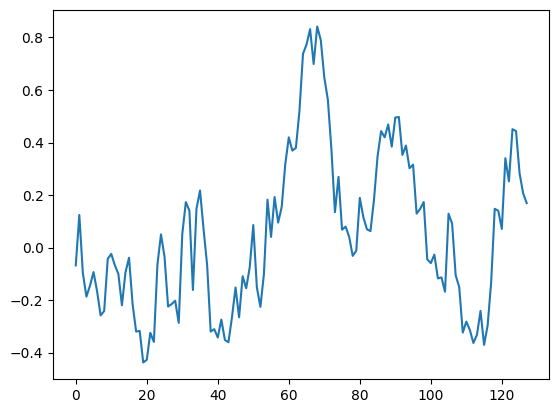

In [195]:
x.sample().plot()

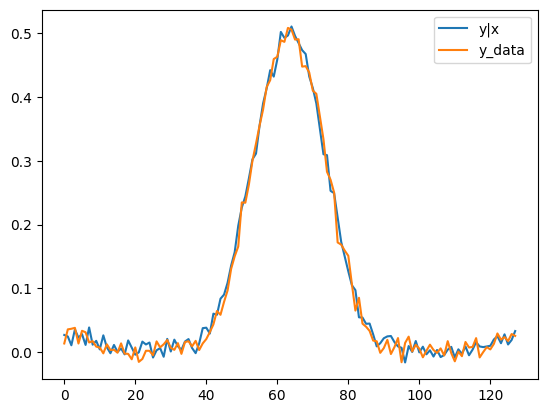

In [196]:
y(x=x_exact).sample().plot()
y_data.plot();
plt.legend(["y|x", "y_data"])

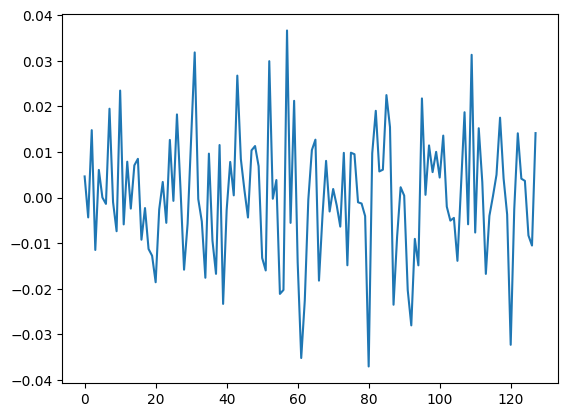

In [171]:
(y(x=x_exact).sample() - y_data).plot()

### Note on notation

It is common (for convenience in terms of notation) not to explicitly write the dependance of each random variable when specifying a complete Bayesian problem. For example, for the case above one would often write
\begin{align*}
\mathbf{x} &\sim \mathrm{GMRF}(\mathbf{0}, d)\\
\mathbf{y} &\sim \mathrm{Gaussian}(\mathbf{A}\mathbf{x}, s_\mathbf{y}^2 I),
\end{align*}

where the dependance of $\mathbf{y}$ on $\mathbf{x}$ is implicit.

This compact notation completely specifies the Bayesian problem for the so-called *data generating process*, making clear all the assumptions about the data and parameters.

In CUQIpy - when all deterministic parameters and forward models are defined - the Bayesian problem is written in code using almost exactly the same syntax as the mathematical notation above.

In [172]:
# Bayesian problem (repeated in case previous cells were modified)
x = GMRF(np.zeros(n), 50)
y = Gaussian(A@x, s_y**2)


# 1.3 Bayesian inverse problem
The simplest way to sample a Bayesian inverse problem in CUQIpy is to use the [BayesianProblem class](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.problem/cuqi.problem.BayesianProblem.html#cuqi.problem.BayesianProblem).

Using the BayesianProblem class, one can easily define and sample from the posterior distribution of a Bayesian inverse problem by providing the distributions for the parameters and data and subsequently setting the observed data.

Calling the `UQ` method on the BayesianProblem object will automatically sample the posterior distribution using a suitable choice of sampling algorithm and plot the results.

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 2.459928274154663
Plotting results


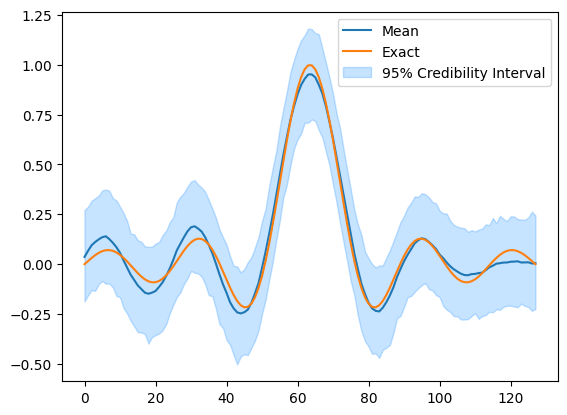

In [198]:
# The simplest way to do uncertainty quantification in CUQIpy:
BP = BayesianProblem(x, y)      # Create Bayesian problem
BP.set_data(y=y_data)           # Provide observed data
samples = BP.UQ(exact=x_exact)  # Run UQ analysis (comparing with exact solution)


In the above example, we provided our assumptions about the data generating process by defining the distributions for the parameters and data and provided the observed data for the problem. CUQIpy then automatically sampled the posterior distribution and a credibility interval for the parameter $\mathbf{x}$ as well as the mean of the posterior was plotted and compared to the ground truth (x_exact).

We see that compared to the ground truth, the mean of the posterior is a good estimate and the credibility interval contains the ground truth.

In the next section, we show how to define the posterior distribution more explicitly and how to sample it with a specific choice of sampler.

# 2 Defining and sampling a Bayesian Inverse Problem (low-level)<a class="anchor" id="Joint"></a>

Instead of relying on the BayesianProblem class to automatically sample the posterior distribution (which does not always work well), we can also define the posterior distribution explicitly and sample it using a specific sampler in CUQIpy. This requires a bit more work, but it gives us more control over the sampling process.

## 2.1 Defining the joint distribution
In the Bayesian framework, we are interested in the joint distribution over $\mathbf{x}$ and $\mathbf{y}$. The joint distribution is defined as the product of the individual probability density functions. In our simple case, the joint distribution can be described in density form as

$$
p(\mathbf{y},\mathbf{x}) = p(\mathbf{y} \mid \mathbf{x})p(\mathbf{x}).
$$

In CUQIpy, if we want more control, we can as an alternative to using BayesianProblem, instead define the joint distribution ourselves by passing each of the distributions as arguments to the [JointDistribution class](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.JointDistribution.html#cuqi.distribution.JointDistribution).

In [199]:
# Define joint distribution p(y,x)
joint = JointDistribution(y, x)


Calling `print` on the joint distribution gives a nice overview matching the mathematical description above.

In [200]:
print(joint)


JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x'].
	x ~ CUQI GMRF.
)


For the purpose of this notebook we are not going to dive further into the details of the joint distribution, and simply use it to define the posterior.

## 2.2 Defining the posterior distribution

To define the posterior distribution, we have to condition the joint distribution $p(\mathbf{y},\mathbf{x})$ on the observed data, say $\mathbf{y}_\mathrm{data}$. This is done by using Bayes' theorem, which in our simple case can easily be derived as

\begin{align*}
p(\mathbf{x} \mid \mathbf{y}=\mathbf{y}_\mathrm{data}) \propto L(\mathbf{x} \mid \mathbf{y}=\mathbf{y}_\mathrm{data})p(\mathbf{x}),
\end{align*}

where we use the notation $L(\mathbf{x} \mid \mathbf{y}=\mathbf{y}_\mathrm{data}) := p(\mathbf{y}=\mathbf{y}_\mathrm{data} \mid \mathbf{x})$ for the likelihood function to emphasize that, in the context of the posterior where $\mathbf{y}$ is fixed to $\mathbf{y}_\mathrm{data}$, it is a function of $\mathbf{x}$ and not on $\mathbf{y}$. In CUQIpy we sometimes use the short-hand printing style `L(x|y)` for brevity.

CUQIpy can automatically derive the posterior distribution for any joint distribution by passing the observed data as an argument to the "call" (condition) method of the joint distribution.  This is done as follows:

In [201]:
posterior = joint(y=y_data) # Condition p(x,y) on y=y_data. Applies Bayes' rule automatically


We can now inspect the posterior distribution by calling `print` on it. Notice that the posterior equation matches the mathematical expression above.

In [177]:
print(posterior)


Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI GMRF.
 )


#### ★ Try yourself (optional):  
The posterior is essentially just another CUQIpy distribution. Have a look at the [Posterior class](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.Posterior.html) in the online documentation to see what attributes and methods are available.

Try evaluating the posterior log probability density function (logpdf) at some point say $\mathbf{1}$ and $2\cdot\mathbf{1}$, where $\mathbf{1}$ is a ones-vector.

Try evaluating the posterior pdf at the same points. Can you explain why the pdf gives the same result for both points?

In [227]:
# Your code here
posterior.logpdf(np.ones(n))

array([-531404.61296425])

In [237]:
posterior.logpdf(x_exact)

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Continuous1D(128,)

Parameters:
 True

Array:
CUQIarray([533.89428051])

In [236]:
posterior.pdf(x_exact)

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Continuous1D(128,)

Parameters:
 True

Array:
CUQIarray([7.3678359e+231])

In [230]:
posterior.pdf(2*np.ones(n))

array([0.])

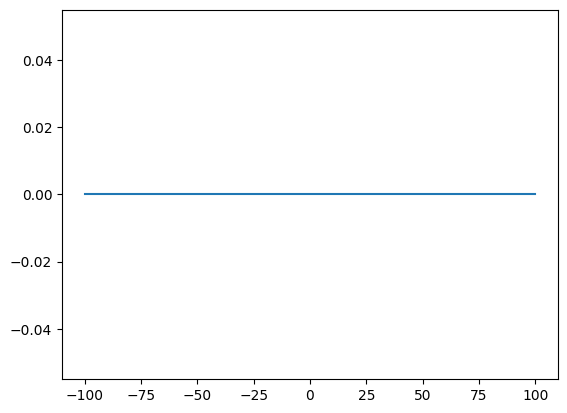

In [235]:
grid = np.linspace(-100, 100, 1001)
plt.plot(grid, [posterior.pdf(node_k*np.ones(n)) for node_k in grid])

# 2.3 Sampling the posterior

Now that we have defined the posterior distribution for our parameter of interest $\mathbf{x}$ given $\mathbf{y}_\mathrm{data}$, we can characterize the parameter and its uncertainty by samples from the posterior distribution. However, in general the posterior is not a simple distribution that we can easily sample from. Instead, we need to rely on Markov Chain Monte Carlo (MCMC) methods to sample from the posterior.

In CUQIpy, a number of MCMC samplers are provided in the sampler module that can be used to sample probability distributions. All samplers have the same signature, namely `Sampler(target, ...)`, where `target` is the target CUQIpy distribution and `...` indicates any (optional) arguments.

In the case of the posterior above, which is defined from a linear model and Gaussian likelihood and prior, the Linear Randomize-then-Optimize [(LinearRTO)](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.LinearRTO.html#cuqi.sampler.LinearRTO) sampler is a good choice to efficiently generate samples. This is also the sampler chosen by the BayesianProblem class for this problem.

 Like any of the other samplers, we set up the sampler by simply providing the target distribution.

In [179]:
sampler = LinearRTO(posterior)


After the sampler is defined we can compute samples via the `sample` method.

In [180]:
samples = sampler.sample(500)


Sample 5 / 500

Sample 500 / 500


Similar to directly sampling distributions in CUQIpy, the returned object is a `cuqi.samples.Samples` object.

This object has a number of methods available. In this case, we are interested in evaluating if the sampling went well. To do this we can have a look at the chain history for 2 different parameters.

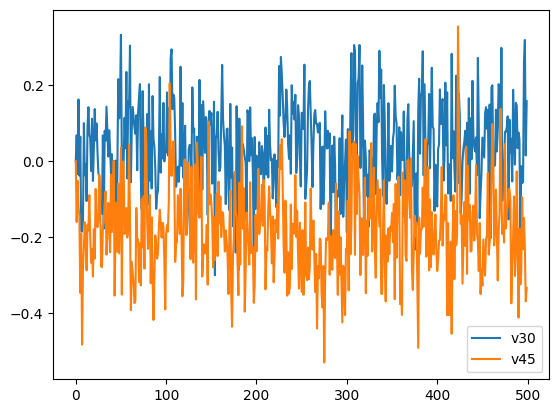

In [181]:
samples.plot_chain([30, 45]);


In both cases the chains look very good with no discernible difference between the start and end of the chain. This is a good indication that the chain has converged and there is little need for removing samples that are part of a "burn-in" period. In practice, the samples should be inspected with more rigor to ensure that the MCMC chain has converged, but this is outside the scope of this notebook.

The good sampling is in large part due to the LinearRTO sampler, which is built specifically for the type of problem of this example. For the sake of presentation let us remove the first 100 samples using the `burnthin` method (see [samples.burnthin](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.samples/cuqi.samples.Samples.burnthin.html#cuqi.samples.Samples.burnthin)) and store the "burnthinned" samples in a new variable.

In [182]:
samples_final = samples.burnthin(Nb=100)


Finally, we can plot a credibility interval of the samples and compare to the exact solution (from `probInfo`).

This is what the `UQ` method of the BayesianProblem class did under the hood for us earlier.

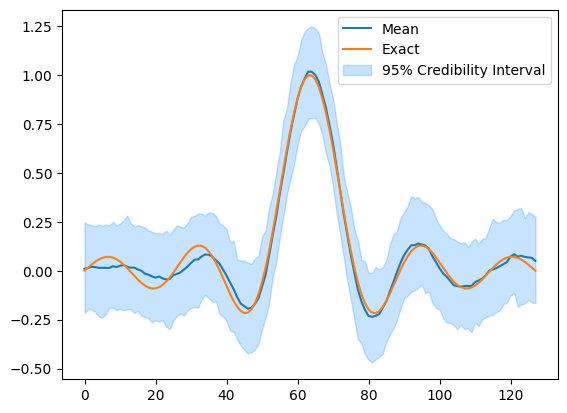

In [183]:
samples_final.plot_ci(95, exact=probInfo.exactSolution)


### Trying out other samples

The LinearRTO sampler can only sample Gaussian posteriors that also have an underlying linear model.

It is possible to try out other CUQIpy samplers (which also work for a broader range of problems). For example:

* **[pCN](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.pCN.html#cuqi.sampler.pCN)** - preconditioned Crank-Nicolson sampler.
* **[CWMH](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.CWMH.html)** - Component-wise Metropolis-Hastings sampler.
* **[ULA](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.ULA.html)** - Unadjusted Langevin Algorithm.
* **[MALA](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.MALA.html)** - Metropolis Adjusted Langevin Algorithm.
* **[NUTS](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.NUTS.html)** - No U-Turn Sampler: A variant of the Hamiltonian Monte Carlo sampler well-established in literature.

Note in particular that ULA, MALA and NUTS all require the gradient of the logpdf. This is handled automatically in CUQIpy for linear models.

#### ★ Try yourself (optional):  

Try sampling the posterior above using one of the suggested samplers (click the links to look at the online documentation for the sampler to get more info on it).

Compare results (chain, credibility interval etc.) to the results from LinearRTO.

All the suggested samplers (except NUTS) will likely require > 5000 samples to give reasonable results, and for some playing with step sizes (scale) is needed. This is because they are not as efficient as LinearRTO or NUTS. For some samplers, the method [sample_adapt](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.sampler/cuqi.sampler.NUTS.sample_adapt.html#cuqi.sampler.NUTS.sample_adapt) will auto-scale the step size according to some criteria, e.g. reach approximately optimal acceptance rate and a burn-in should be added to specify how many samples to use for the adaptation.



In [184]:
# Your code here





# 3. Exploring different prior choices<a class="anchor" id="ModifyPriors"></a>

In the above example, we used a GMRF prior for the parameter $\mathbf{x}$. However, it is not always obvious what prior to use for a given problem. In such cases, it is often useful to try out different priors to see how they affect the posterior distribution.

In CUQIpy, it is easy to modify the prior and re-sample the posterior distribution. This is most easily done by using the BayesianProblem class.

####  Try yourself (optional):  

Please carry out the following exercise to see how the prior affects the posterior distribution. 

Note that: here we use the [sample_posterior](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.problem/cuqi.problem.BayesianProblem.sample_posterior.html#cuqi.problem.BayesianProblem.sample_posterior) method of the BayesianProblem class to sample the posterior distribution and store the samples without plotting. We then manually plot the samples using the `plot_ci` method of the `Samples` object.

- Try another prior such as [LMRF](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.LMRF.html#cuqi.distribution.LMRF) or [CMRF](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.CMRF.html#cuqi.distribution.CMRF) for the 1D case (look up appropriate arguments in the documentation) using [`BayesianProblem`](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.problem/cuqi.problem.BayesianProblem.html#cuqi.problem.BayesianProblem).
- Try switching the testproblem from Deconvolution1D to [Deconvolution2D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Deconvolution2D.html#cuqi.testproblem.Deconvolution2D) (look up appropriate arguments in the documentation).
- You may also try defining your own Bayesian inverse problem using this interface. ★

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using LinearRTO sampler.
burn-in: 20%
Sample 600 / 600
Elapsed time: 1.2722704410552979


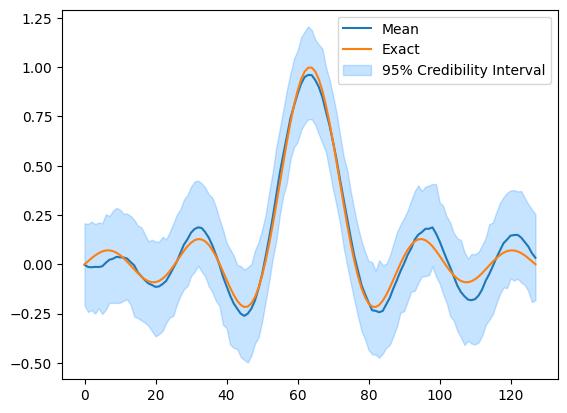

In [185]:
# Your code here
# You can modify this code or write your own from scratch

# 1. Forward model and data
A, y_data, probInfo = Deconvolution1D(phantom="sinc").get_components()

# 2. Distributions
x = GMRF(np.zeros(A.domain_dim), 50) # Try e.g. LMRF or CMRF (also update scale parameters!)
y = Gaussian(A@x, 0.01**2)

# 3. Bayesian problem
BP = BayesianProblem(y, x).set_data(y=y_data)

# 4. Sample posterior
samples = BP.sample_posterior(500)

# 5. Analyze posterior
samples.plot_ci(exact=probInfo.exactSolution)


You may have noticed that finding suitable parameters for the prior could be a challenge. To see how to automatically find suitable parameters for the prior, see the [Gibbs notebook](Exercise06_Gibbs.ipynb).

# 4. Computing point estimates of the posterior ★ <a class="anchor" id="pointestimates"></a>

In addition to sampling the posterior, we can also compute point estimates of the posterior. A common point estimate to consider is the Maximum A Posteriori (MAP) estimate, which is the value of the Bayesian parameter that maximizes the posterior density. That is,

\begin{align*}
\mathbf{x}_\mathrm{MAP} = \arg\max_\mathbf{x} p(\mathbf{x} \mid \mathbf{y}_\mathrm{data}).
\end{align*}

The easiest way to compute the MAP estimate is to use the `MAP` method of the `BayesianProblem` class as follows:

In [186]:
# We redefine in case something was changed

# Deterministic forward model
A, y_data, probInfo = Deconvolution1D(phantom="sinc").get_components()

# Distributions for each parameter
x = GMRF(np.zeros(A.domain_dim), 50)
y = Gaussian(mean=A@x, cov=0.01**2)

# Define Bayesian problem
BP = BayesianProblem(y, x).set_data(y=y_data)


In [187]:
x_map = BP.MAP() # Maximum a posteriori estimate


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic solver selection is experimental. !!!
!!!    Always validate the computed results.    !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Optimizing with exact gradients
Using scipy.optimize.minimize on negative log of Posterior
x0: ones vector


The automatic solver selection is also still work-in-progress.

After we have computed the MAP, we can then estimate to the exact solution (from `probInfo`)

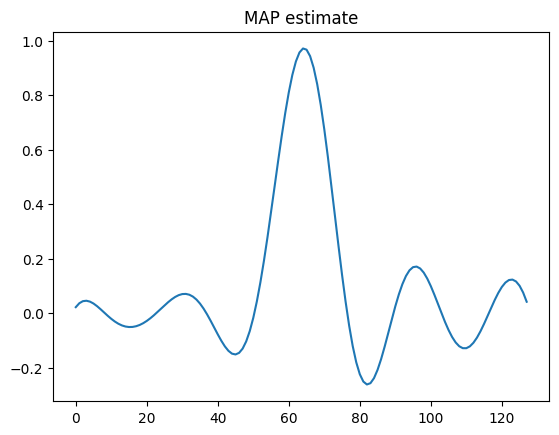

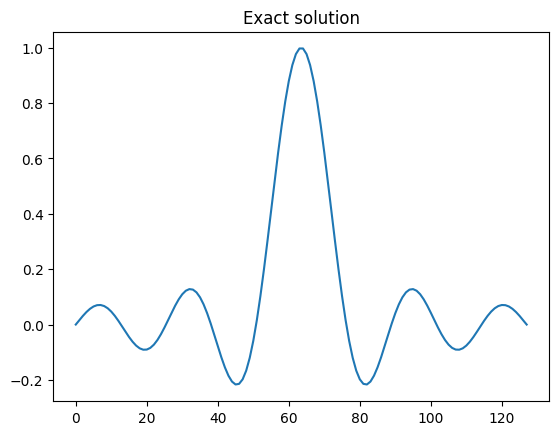

In [188]:
x_map.plot()
plt.title('MAP estimate')
plt.show()

probInfo.exactSolution.plot()
plt.title('Exact solution')
plt.show()


#### ★ Try yourself (optional):  

- Try switching to the Deconvolution2D testproblem. You may have to play with the prior standard deviation to get a good MAP estimate.
- Try switching the prior to a CMRF distribution for the 1D case. Does the MAP estimate change?